In [1]:
# !git clone https://github.com/vincentnam/ProjetInterpromo2020G8.git

Standard Python >= 3.5 -> preprocess colours a été ajouté.
OpenCV4.1.2.30 -> rgb to grey a été ajouté.
OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas a été ajouté.
Standard Python >= 3.5 -> preprocess colours
OpenCV4.1.2.30 -> rgb to grey
OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas


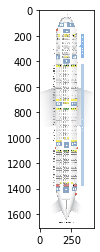

Début du pipeline : 
Preprocess :  Standard Python >= 3.5 -> preprocess colours
Doing : Standard Python >= 3.5 -> preprocess colours


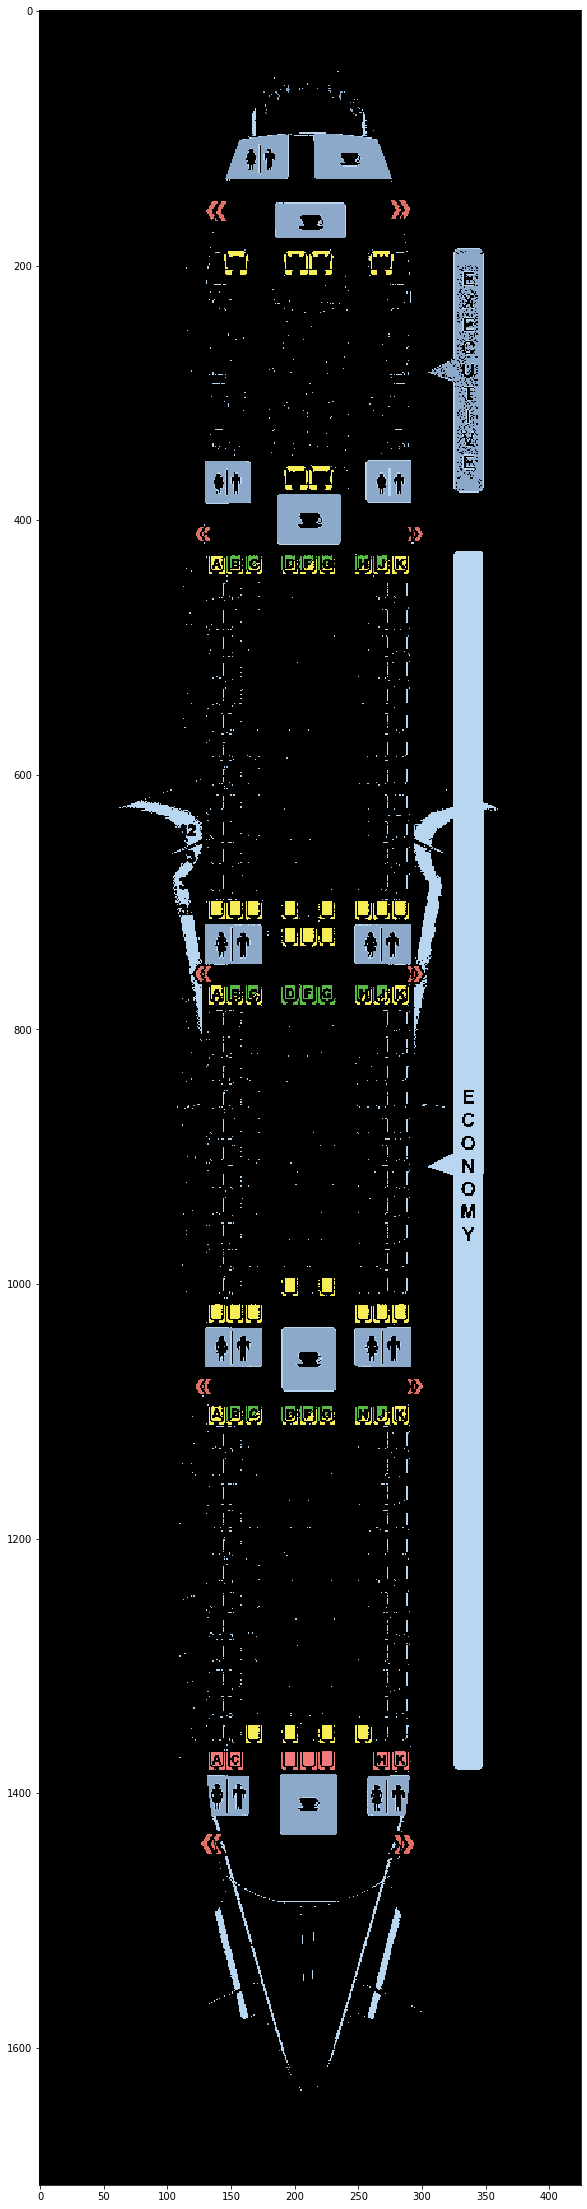

Preprocess :  OpenCV4.1.2.30 -> rgb to grey
Doing : OpenCV4.1.2.30 -> rgb to grey


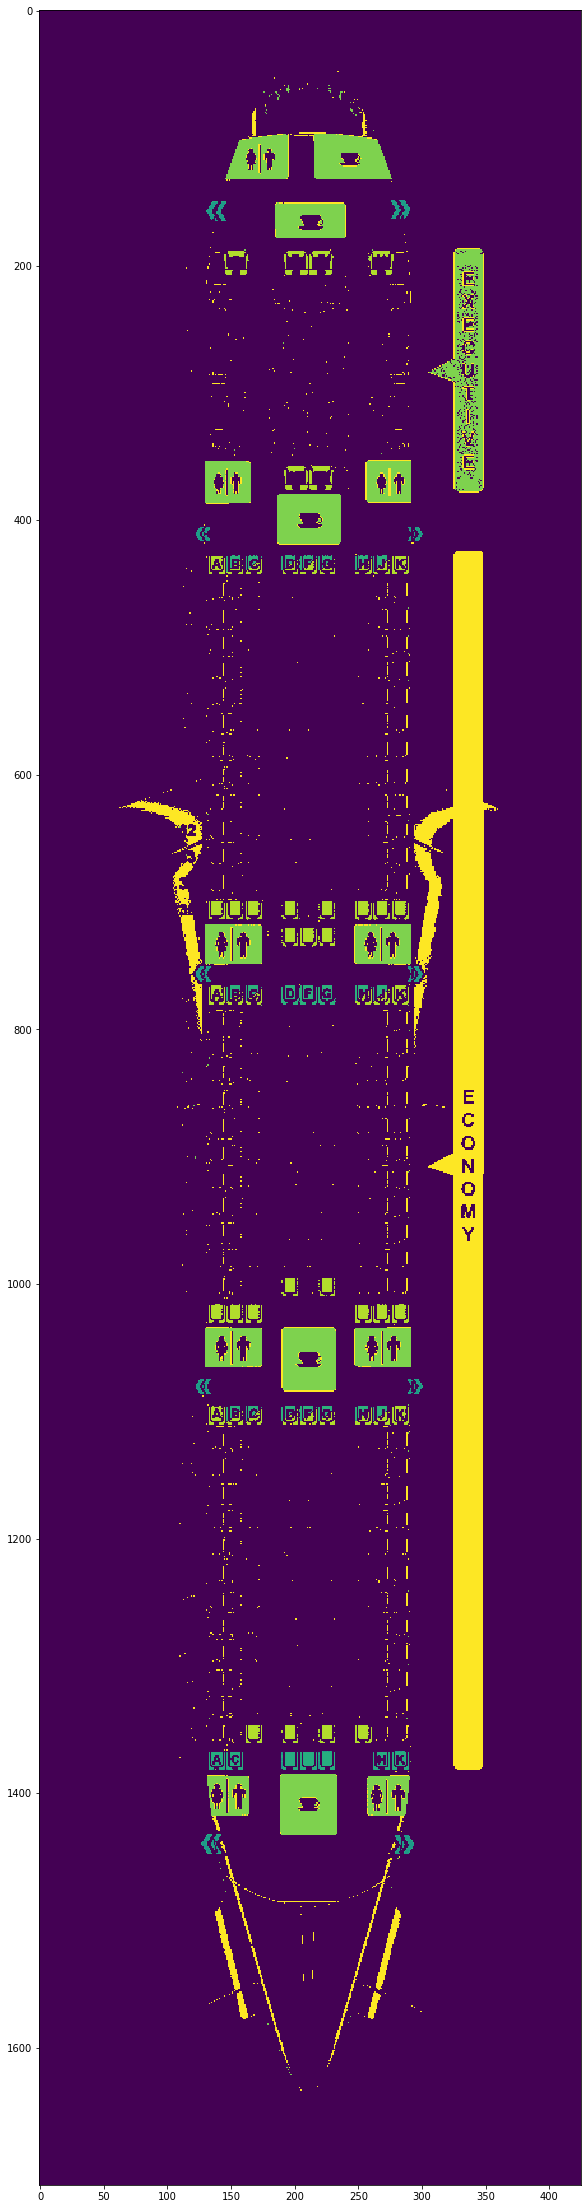

Process :  OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas
Doing : OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas


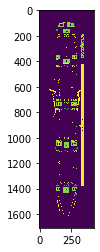

In [2]:
from abc import ABCMeta, abstractmethod
from typing import Iterable

import numpy as np
from pipeline import Process, Preprocess, Postprocess, Pipeline, overrides, MetaProcess, NotProcessClass


import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
from collections import defaultdict
from PIL import Image

from matplotlib import image
import matplotlib.patches as mpatches
from skimage import io
import skimage.segmentation as seg
from skimage.segmentation import clear_border
import skimage.filters as filters
from skimage.filters import threshold_otsu
import skimage.draw as draw
import skimage.color as color
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage.morphology import closing, square


from skimage.measure import label, regionprops
import numpy as np
import pandas as pd
import os
import cv2 as cv2

from matplotlib import pyplot as plt
from matplotlib import image
import matplotlib.patches as mpatches

from skimage import io
import skimage.segmentation as seg
from skimage.segmentation import clear_border
import skimage.filters as filters
from skimage.filters import threshold_otsu
import skimage.draw as draw
import skimage.color as color
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage.morphology import closing, square

# Preprocessing definition

In [3]:
class ColourPipelineSeat(Preprocess):
    process_desc = "Standard Python >= 3.5 -> preprocess colours"
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def run(self, **kwargs) -> Iterable:
        return self.col_obj.colour_pipeline(colours = {}, epsilon = 40, colour_mode = False, 
                            default_colour = [255, 255, 255], rgb_len = 3)
    
    
class BlackWhite(Preprocess):
    process_desc = "OpenCV4.1.2.30 -> rgb to grey"
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def run(self, **kwargs) -> Iterable:
        return self.col_obj.util_obj.to_gray() 
        
        
class ColourPipelineZones(Preprocess):
    process_desc = "Standard Python >= 3.5 -> preprocess colours"
    def __init__(self,*args, **kwargs):
        super().__init__(*args, **kwargs)
    def run(self, **kwargs) -> Iterable:
        return self.col_obj.colour_pipeline(colours = {}, epsilon = 30, colour_mode = True, 
                        default_colour = [0, 0, 0], rgb_len = 3).astype('uint8')
    

## Processing definition

In [23]:
class SegmentationZone(Process):
    process_desc = "OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas"

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def image_process_label(self, image):
        # grayscale = rgb2gray(image)
        thresh = threshold_otsu(image)
        bw = closing(image > thresh, square(2))
        cleared = clear_border(bw)
        label_image = label(cleared)
        return label_image

    def label_results(self, image, json, data_image=None,
                      min_rectangle_area=80):
        # the result will be store in this list
        image_detection_result = []
        if data_image is None:
            print("Data_image is None")
        # get the image

        # get the different area
        label_image = self.image_process_label(image)
        props = regionprops(label_image)

        # prepare the image info
        json[data_image.split('/')[-1]] = {"areas": [], "rectangles": [],
                                           "diameters": [], "coordinates": []}
        #         image_detection_result.append({
        #             'image_name': image_path.split('/')[-1],
        #             "areas": [],
        #             "rectangles": [],
        #             "diameters": [],
        #             "coordinates": []
        #         })

        # the last index in the list
        len_list = len(image_detection_result) - 1

        # by region find every rectangle that will interesting us
        for region in props:
            # bigger enough area chosen
            if region.area >= min_rectangle_area:
                json[data_image.split('/')[-1]]['areas'].append(region['Area'])
                json[data_image.split('/')[-1]]['rectangles'].append(
                    region['BoundingBox'])
                json[data_image.split('/')[-1]]['diameters'].append(
                    region['EquivDiameter'])
                json[data_image.split('/')[-1]]['coordinates'].append(
                    region['Coordinates'])

    def image_detection_result(self, image_name, im_pre, limit_area):
        # image_name : image chosen
        # data_path : path to access those images
        # layouts : seatguru or seatmaestro
        # limit_area : minimum dimension area, 80 by default

        # the result will be store in this list
        image_detection_result = []

        # detect the regions of an image
        label_image = self.image_process_label(im_pre)
        props = regionprops(label_image)

        # prepare the image info
        image_detection_result.append({
            'image_name': image_name,
            "areas": [],
            "rectangles": [],
            "diameters": [],
            "coordinates": []
        })

        # the last index in the list
        len_list = len(image_detection_result) - 1

        # by region find every rectangle that will interesting us
        for region in props:

            # bigger enough area chosen
            if region.area >= limit_area:
                image_detection_result[len_list]['areas'].append(
                    region['Area'])
                image_detection_result[len_list]['rectangles'].append(
                    region['BoundingBox'])
                image_detection_result[len_list]['diameters'].append(
                    region['EquivDiameter'])
                image_detection_result[len_list]['coordinates'].append(
                    region['Coordinates'])

        return image_detection_result

    def coord_template_matching_image_single(self, image, json, liste_temp,
                                             path_temp, image_name,threshold,
                                             limit_area = 80):
        # liste_temp : list of templates
        # path_temp : path to access the list of templates
        # image_name : image
        # data_path : path to access the image
        # layouts : list of layouts
        # threshold : chosen, by default 0.9
        # limit_area : minimum dimension area, 80 by default

        # Initialize the dictionnary which will display the results
        temp_rcgnzd = {}

        # Pre-process the image


        # Image rgb to gray

        dict_data = self.image_detection_result(image_name,image, 80)

        # Initialize dictionnary of templates type for the image
        type_temp = {}

        for templ in liste_temp:
            # Initialize list of (all) coordinates for each recognized template
            liste_position = []
            # Open template
            template = cv.imread(path_temp + templ, 0)
            h, w = template.shape

            # List of match
            res = cv.matchTemplate(image, template, cv.TM_CCOEFF_NORMED)

            position = [pos for pos in zip(*np.where(res >= threshold)[::-1])]

            for pos in position:
                # Draw rectangle around recognized element
                cv.rectangle(
                    image, pos, (pos[0] + w, pos[1] + h), (255, 255, 255), 2)

                for rect in json[image_name]['rectangles']:

                    if pos[0] > rect[1] and pos[0] < rect[3] and pos[1] > rect[
                        0] and pos[1] < rect[2]:

                        if rect not in liste_position:
                            liste_position.append(rect)

            type_temp[templ] = (liste_position)

            json[image_name] = type_temp

        #return temp_rcgnzd

    def run(self, image, json, image_rgb=None, col_obj=None, templates=None,
            data_image=None, image_name = None, **kwargs) -> None:
        plt.imshow(image)
        plt.show()
        self.label_results(image, json, data_image)
        temp_zone_fold_path = "./images/zone_templates/"
        list_temp = [name_template for name_template in os.listdir(temp_zone_fold_path)]
        print(list_temp)
        self.coord_template_matching_image_single(image, json, image_name= image_name,
                                                  liste_temp=list_temp,
                                                  path_temp=temp_zone_fold_path,
                                                  threshold=0.5)
        

In [24]:
# # Input list of pre-processed images
# liste_prepro_images = os.listdir("C:/Users/marce/Documents/interpromo_2020"
#                                  "/images_test")

# # list of defined templates
# liste_temp = os.listdir(
#     "C:/Users/marce/Documents/interpromo_2020/templates/templates_to_use")

# # path to access all images
# data_path = 'C:/Users/marce/Documents/interpromo_2020/AllData/ANALYSE IMAGE/'

# # list of both layouts
# layouts = ['LAYOUT SEATGURU', 'LAYOUT SEATMAESTRO']

# # image name used for test
# image_name = 'Oman_Air_Boeing_737-700_new_plane686.jpg'

# # path to access pre-processed images
# path_images_test = "C:/Users/marce/Documents/interpromo_2020/images_test/"

# # empty directory
# out_dir_temp = "C:/Users/marce/Documents/interpromo_2020/templates/"

# # path to access all defined templates 
# path_list_temp = "C:/Users/marce/Documents/interpromo_2020/templates/templates_to_use/"





# y = coord_template_matching_image_single(liste_temp, path_list_temp,
#                                          image_name, data_path, layouts, 0.5, 80)

In [30]:

class SeatFinder(Process):
    process_desc = "OpenCV4.1.2.30 -> Pattern Matching seat"

    def __init__(self, csv_data_path=None, *args, **kwargs):
        if csv_data_path is None:
            raise Exception("Data_path is empty in init function of " + str(
                self.__class__))
        super().__init__()
        self.csv_data_path = csv_data_path
        self.layout_folder_path = csv_data_path + "ANALYSE IMAGE/"
        self.seatguru_image_data_path = self.layout_folder_path + "LAYOUT SEATGURU/"
        self.seatmaestro_image_data_path = self.layout_folder_path + "LAYOUT SEATMAESTRO/"

    def hasNumbers(self, inputString):
        return any(char.isdigit() for char in inputString)

    def longestValue(self, inputList):
        if len(inputList) > 0:
            max_len = 0
            for i, el in enumerate(inputList):
                if len(el) > max_len:
                    max_len = i
            return inputList[max_len]
        return 0

    def get_relevant_aircraft_builders(self, image_names,
                                       proportion_min=0.02,
                                       proportion_max=0.75):
        # retrieve aircraft types

        aircraft_builders = np.unique(
            [a_type.split(' ')[0].lower() for a_type in
             pd.read_csv(
                 self.csv_data_path + 'SEATGURU_INFO_AIRCRAFT.csv',
                 sep=';')['Aircraft_Type'].tolist() if
             len(a_type.split(' ')) > 1])

        # remove aircraft_builder that have Numerics in it
        aircraft_builders = [a_builder for a_builder in aircraft_builders if
                             not self.hasNumbers(a_builder) and len(
                                 a_builder) > 2]

        # remove aircraft with too low occurences in the "IMAGES_NAMES" list
        relevant_aircraft_builders = {}
        for a_builder in aircraft_builders:
            proportion = sum(
                [1 for img_n in image_names if
                 a_builder in img_n.lower()]) / len(
                image_names)
            if proportion > proportion_min and proportion < proportion_max:
                relevant_aircraft_builders[a_builder] = proportion

        # remove non aircradft builder that remain
        del relevant_aircraft_builders['airlines']
        del relevant_aircraft_builders['irbus']
        del relevant_aircraft_builders['airways']
        del relevant_aircraft_builders['ays']

        # sort by proportion
        relevant_aircraft_builders = {k: v for k, v in
                                      sorted(
                                          relevant_aircraft_builders.items(),
                                          key=lambda item: item[1])}
        return relevant_aircraft_builders

    def get_airline_aircraft_builder_pos(self, image_names, aircraft_builders,
                                         airlines, aircraft_ref, pattern,
                                         layout="LAYOUT SEATGURU/"):
        # Initialisation of dict
        dictio_airlines_aircraft_builders = []

        for image_name in image_names:

            size = Image.open(
                self.layout_folder_path + layout + image_name).size

            dictio_airlines_aircraft_builders.append({
                'image_name': image_name,
                'aircraft_builder': 'not_relevant_aircraft_builders',
                'position_aircraft_builder': -1,
                'airline': '',
                'aircraft_ref': [],
                'x_size': int(size[0]),
                'y_size': int(size[1])
            })

            # a little pre-process to clean-up image name
            img_inf = image_name.lower().split('.')[0].split(pattern)

            for i, item in enumerate(img_inf):
                for a_builder in aircraft_builders:
                    # check if the image contains the aircraft builder
                    if a_builder == item:
                        # add the aircraft builder in the image name
                        dictio_airlines_aircraft_builders[-1][
                            'aircraft_builder'] = a_builder
                        dictio_airlines_aircraft_builders[-1][
                            'position_aircraft_builder'] = i

            # add airlines deduce by the image name
            for airline in airlines:
                if airline + pattern in image_name.lower():
                    dictio_airlines_aircraft_builders[-1][
                        'airline'] = airline

            # add aircraft_ref
            for a_ref in aircraft_ref:
                if a_ref in image_name.lower():
                    dictio_airlines_aircraft_builders[-1][
                        'aircraft_ref'].append(a_ref)
            # take the longest str element in the list of ref
            dictio_airlines_aircraft_builders[-1][
                'aircraft_ref'] = self.longestValue(
                dictio_airlines_aircraft_builders[-1]['aircraft_ref'])

        return dictio_airlines_aircraft_builders

    def main_layout_seatguru(self, layout="LAYOUT SEATGURU/"):
        image_name_list = [img for img in
                           os.listdir(self.layout_folder_path + layout)]

        relevant_aircraft_builders = self.get_relevant_aircraft_builders(
            image_name_list)
        airlines = \
            pd.read_csv(self.csv_data_path + 'SEATGURU_INFO_AIRCRAFT.csv',
                        sep=';')[
                'Airline_name'].unique()
        airlines = [airline.replace('-', '_') for airline in airlines]

        aircraft_ref = np.unique([a_type.lower() for a_type in pd.read_csv(
            self.csv_data_path + 'SEATGURU_INFO_AIRCRAFT.csv', sep=';')[
            'Aircraft_Type'].tolist()])
        aircraft_ref = np.unique(
            [t for text in aircraft_ref for t in text.split(' ') if
             self.hasNumbers(t)])

        dictio_airlines_aircraft_builders = self.get_airline_aircraft_builder_pos(
            image_name_list, relevant_aircraft_builders, airlines,
            aircraft_ref,
            '_')
        return pd.DataFrame(dictio_airlines_aircraft_builders)

    def get_correspondance(self, dataframe):
        # retrieve aircraft builders
        aircraft_builders = dataframe['aircraft_builder'].tolist()
        # retrieve arcraft references
        aircraft_refs = dataframe['aircraft_ref'].tolist()
        # retrieves airline names
        airlines = dataframe['airline'].tolist()
        # retrieve image names
        image_names = dataframe['image_name'].tolist()

        df_seat_guru_info = pd.read_csv(
            self.csv_data_path + 'SEATGURU_INFO_AIRCRAFT.csv', sep=';')
        aircraft_type = df_seat_guru_info['Aircraft_Type']
        # dictionnary where the info will be stored
        dictio = {}
        # for each aircraft builder, aircraft ref, airline and image name,
        # we research the relevant information in df_seat_guru_info dataframe
        for a_b, a_r, airline, im in \
                zip(aircraft_builders, aircraft_refs, airlines, image_names):
            res = pd.DataFrame([df_seat_guru_info.loc[i] for i, a_t in
                                enumerate(aircraft_type) if
                                a_b in a_t.lower() and a_r in a_t.lower()]).reset_index()
            if 'Airline_name' in res.columns:  # res not empty right after the research
                res = pd.DataFrame([res.loc[i] for i, a_n in
                                    enumerate(res['Airline_name'].tolist()) if
                                    airline.replace('_', '-') in a_n.lower()])
                if 'Total_seat' in res.columns:  # res not empty right after the research
                    # get the maximum of seat number
                    nb_max_seats = max(res['Total_seat'].unique().tolist())
                    # select the seats with the help of nb_max_seats
                    res['selected'] = res['Total_seat'].apply(
                        lambda x: 1 if x == nb_max_seats else 0)
                    # select the column that we need
                    res = res[['Category', 'Count', 'Seat_Type', 'selected']]
                    res = res[res[
                                  'selected'] == 1].drop_duplicates()  # remove duplicated lines
                    dictio[im] = res.drop(columns=['selected'])
        return dictio

    def retrieve_relevant_seat_info(self, dictio, image_name):
        total_seat_info = []
        for i, row in dictio[image_name].iterrows():
            total_seat_info.append({
                'Category': row['Category'],
                'Seat_Type': row['Seat_Type'],
                'Count': row['Count']
            })
        return total_seat_info

    def coord_pattern_finder(self, image, template, threshold: float):
        """
        input:
            image : image plane cv2.imread() black and white
            template : image pattern cv2.imread() black and white
            threshold : threshold for this pattern
        output:
            position : list right angle position for this pattern on the image
        """
        position = []  # Variable output
        # List of match
        print(image[0][0], template[0][0])
        res = cv.matchTemplate(image, template, cv.TM_CCOEFF_NORMED)

        for pos in zip(*np.where(res >= threshold)[::-1]):
            position.append(pos)
        return (position)

    def templ_category(self, path='./images/TEMPLATE/', category='BUSINESS',
                       seat_type='STANDARD', plane_name='test.jpg'):
        """
        Create list of template open with cv2 by category and seatType
        Input:
            Path: directory path of templates
            category: name of category
            seatType: Seat type
            planeName: plane name
        Output:
            templates: list of template name
        """
        if '.png' in plane_name:
            extension = 'PNG/'
        else:
            extension = 'JPG/'

        imagesTemp = os.listdir(path + category + '/' + extension)
        templates = []

        for i in imagesTemp:
            if seat_type in i:
                templates.append(cv.imread(
                    path + category + '/' + extension + i, 0))
        return (templates)

    def template_from_template(self, img, template, thresholdMin=0.70):
        """
        intput:
            img : image plane
            template : template
            thresholdMin : threshold min to keep template or not
        output:
            template, boolean : true if found
        """
        # default Threshold
        threshold = 1
        position = self.coord_pattern_finder(img, template, threshold)
        h, w = template.shape
        # Reduce Threshold while no template match
        while len(position) < 1 and threshold > thresholdMin:
            threshold -= 0.005
            position = self.coord_pattern_finder( img, template,
                                                 threshold)

        if threshold > thresholdMin:
            return(img[position[0][1]:position[0][1] + h,
                       position[0][0]:position[0][0] + w], True)
        return(None, False)


    def count_list(self, list):
        """
        input:
            list : list
        output:
            ordored list with single occurence
        """
        dictio_count = {}
        for el in list:
            dictio_count[el] = list.count(el)
        return {k: v for k, v in sorted(dictio_count.items(),
                                        key=lambda item: item[1],
                                        reverse=True)}

    def best_position(self, img, template, nbSeat, step=0.005,
                      thresholdMin=0.65):
        """
        input:
            img : image plane
            template : template find from this image
            nbSeat : integrer - for this cat
            steps : steps for threshold
        output:
            position : coord for each match
        """
        position = []
        for threshold in np.arange(thresholdMin, 1 + step, step):

            position += self.coord_pattern_finder(img, template, threshold)

        result = list(self.count_list(position).keys())
        if len(result) < nbSeat * 1.1:
            return (result)
        return (result[:int(nbSeat * 1.1)])

    def run(self, image, json, planes_data_csv=None, image_name=None,
            layout=["LAYOUT SEATGURU/", "LAYOUT SEATMAESTRO/"],
            path='./images/', **kwargs):
        """
            input:
                img : image plane
                nbObjectToFind : Dictionnary : {
                                                'Total_seat': nbSeatTotal,
                                                'business': nbBusinessSeat,
                                                'bar': nbBar
                                                }
                diction : diction output
                planeName :
                path : path for template directory
            output:
                diction : dictionnary {'class':[
                                            (coordX1, coordY1, h, w),
                                            (coordX2, coordY2, h, w)
                                        ]}
        """
        if planes_data_csv is None:
            print("Coucou planes ")
        if image_name is None:
            print("Coucou planes name")
        if not image_name in json.keys():
            json[image_name] = {}
        df_layout_seatguru = self.main_layout_seatguru(layout[0])
        dictio_correspondance = self.get_correspondance(
            df_layout_seatguru[df_layout_seatguru['image_name'] == image_name])
        nbObjectToFind = self.retrieve_relevant_seat_info(
            dictio_correspondance, image_name)

        #       df_layout_seatguru = self.main_layout_seatguru(layout)

        #      dictio = self.get_correspodance(df_layout_seatguru)

        #        nbOjbjectToFind = self.retrieve_relevant(dictio, im_names)

        for objet in nbObjectToFind:
            if not objet["Category"] in json[image_name].keys():
                json[image_name][objet['Category']] = []
            # Take all template name for this category
            templates = self.templ_category(
                category=objet['Category'],
                seat_type=objet['Seat_Type'],
                plane_name=image_name)
            for templ in templates:
                templateFind, find = self.template_from_template(image,
                                                                 templ)
                if find:
                    position = self.best_position(image, templateFind, objet['Count'])

                    h, w = templ.shape
                    for i in range(len(position)):
                        position[i] = position[i] + (h, w)
                    json[image_name][objet['Category']] += position


# Post processing definition

In [31]:
class RemoveDouble(Postprocess):
    process_desc = "Standard Python >= 3.5 -> remove double point in list"
    def __init__(self, *args, **kwargs):
        super().__init__()
    def remove_duplicate(self,coordinate: list):
        """Documentation
        Parameters:
            coordinate: original coordinates without treatment
        Out:
            dup: list of coordinate which are duplicated
        """
        dup = []
        print(coordinate)
        for point1 in coordinate:
            for point2 in coordinate:
                if point2 != point1 and point1 not in dup:
                    if ((abs(point1[0] - point2[0]) <= 5) and (abs(point1[1] - point2[1]) <= 5)):
                        dup.append(point2)
        for d in dup:
            if d in coordinate:
                coordinate.remove(d)
        return(coordinate)

    def run(self, json, **kwargs):
        for seat_index in json:
            json[seat_index] = self.remove_duplicate(json[seat_index])
            


In [34]:
pipeline = Pipeline("/data/dataset/projetinterpromo/Interpromo2020/","Aer_Lingus_Airbus_A330-300_A_plane6.jpg")
pipeline.add_processes([BlackWhite,SeatFinder, RemoveDouble])

OpenCV4.1.2.30 -> rgb to grey a été ajouté.
OpenCV4.1.2.30 -> Pattern Matching seat a été ajouté.
Standard Python >= 3.5 -> remove double point in list a été ajouté.


OpenCV4.1.2.30 -> rgb to grey
OpenCV4.1.2.30 -> Pattern Matching seat
Standard Python >= 3.5 -> remove double point in list


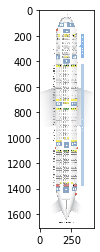

Début du pipeline : 
Preprocess :  OpenCV4.1.2.30 -> rgb to grey
Doing : OpenCV4.1.2.30 -> rgb to grey


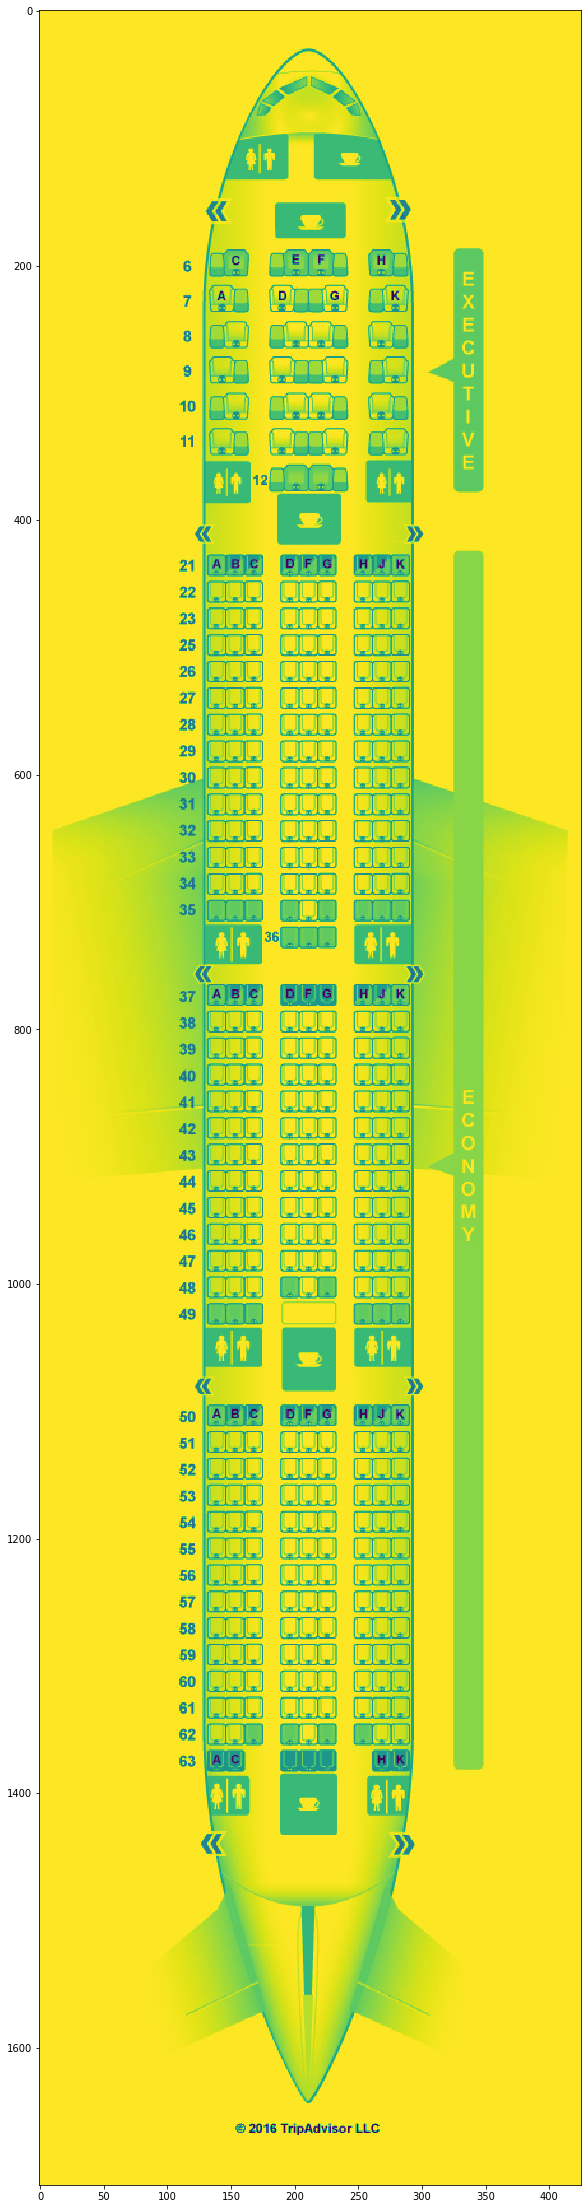

Process :  OpenCV4.1.2.30 -> Pattern Matching seat
Doing : OpenCV4.1.2.30 -> Pattern Matching seat
Coucou planes 
255 255
255 255
255 255
255 255
255 255
255 255
255 255
255 255
255 255
255 255
255 255
255 255
255 255
255 255
255 255
255 255
255 255
255 255
255 255
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 239
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 241
255 24

  File "/data/git-clone/ProjetInterpromo2020G8/pipeline.py", line 597, in run_pipeline
    post_pro.run(self.json,image_name = image_name, **kwargs)
  File "<ipython-input-31-b77a2babed25>", line 26, in run
    json[seat_index] = self.remove_duplicate(json[seat_index])
  File "<ipython-input-31-b77a2babed25>", line 17, in remove_duplicate
    if ((abs(point1[0] - point2[0]) <= 5) and (abs(point1[1] - point2[1]) <= 5)):


In [35]:
pipeline.run_pipeline(1, planes_data_csv=None, plane_name="Aer_Lingus_Airbus_A330-300_A_plane6.jpg", csv_data_path="/data/dataset/projetinterpromo/Interpromo2020")

Standard Python >= 3.5 -> preprocess colours a été ajouté.
OpenCV4.1.2.30 -> rgb to grey a été ajouté.
OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas a été ajouté.
Standard Python >= 3.5 -> preprocess colours
OpenCV4.1.2.30 -> rgb to grey
OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas


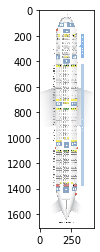

Début du pipeline : 
Preprocess :  Standard Python >= 3.5 -> preprocess colours
Doing : Standard Python >= 3.5 -> preprocess colours


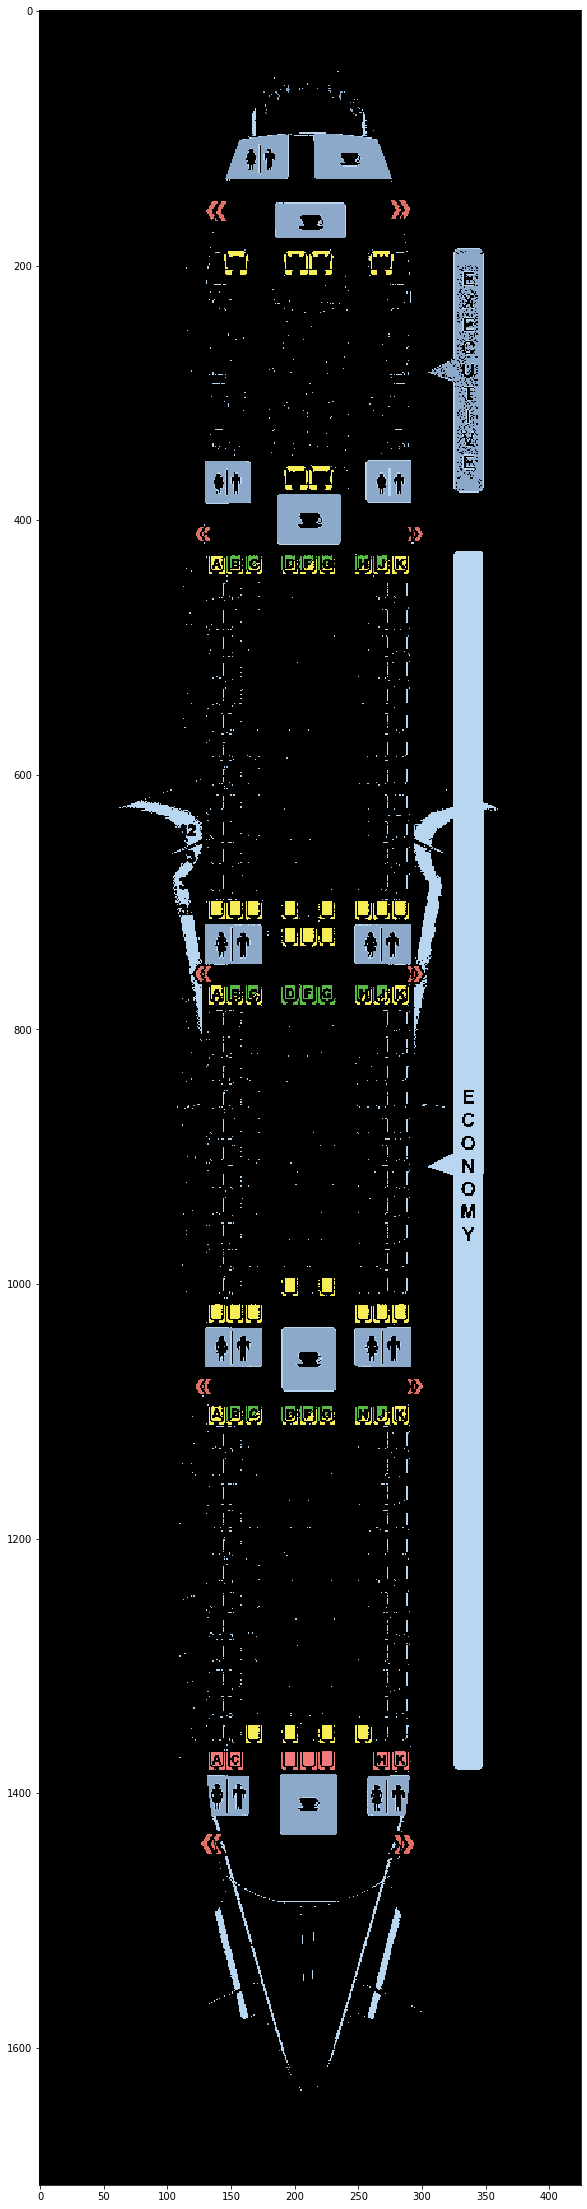

Preprocess :  OpenCV4.1.2.30 -> rgb to grey
Doing : OpenCV4.1.2.30 -> rgb to grey


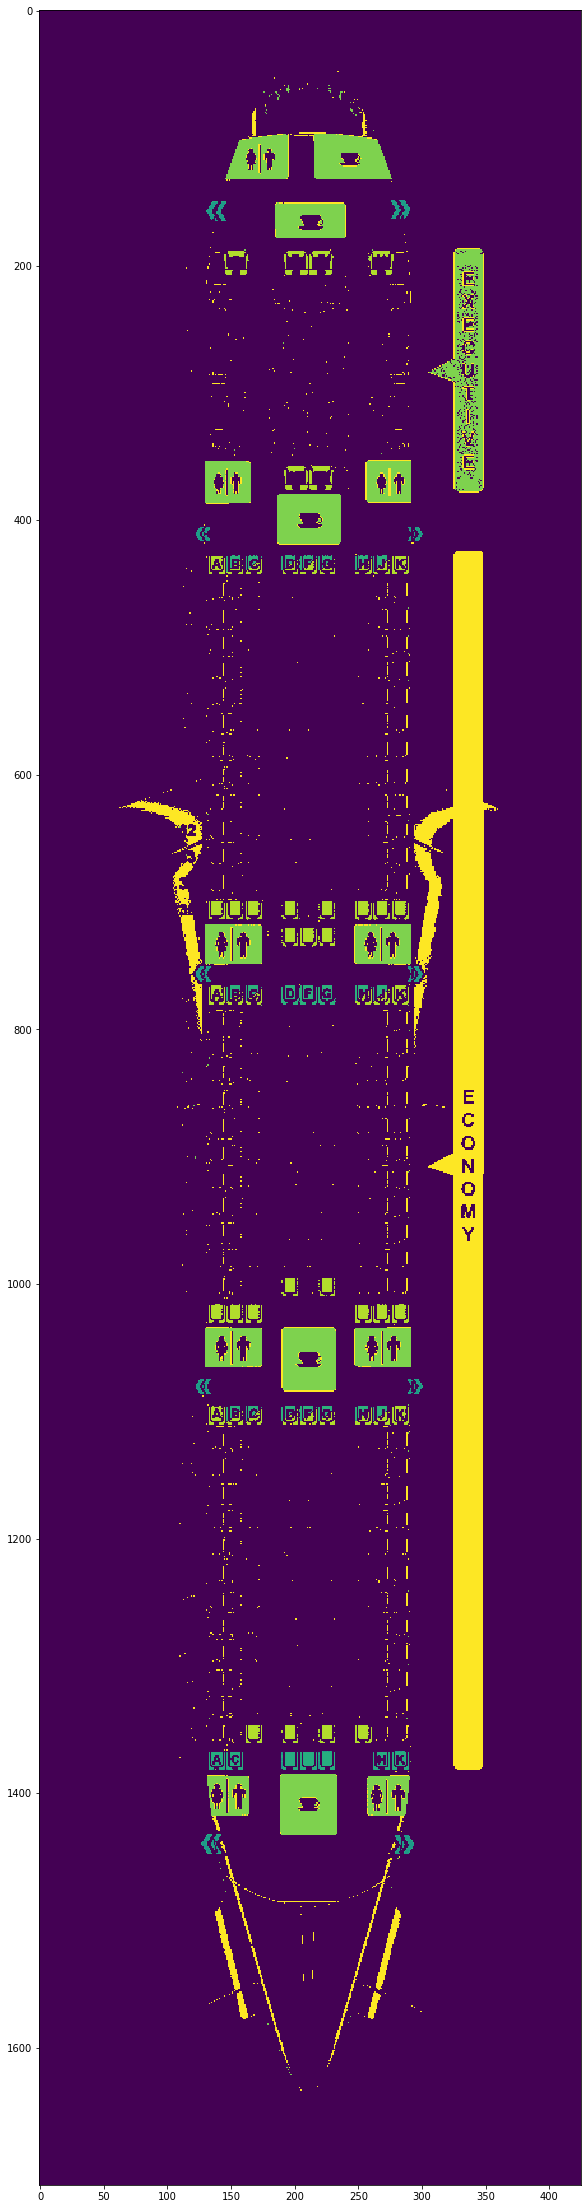

Process :  OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas
Doing : OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas


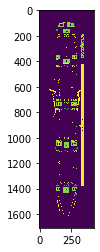

['bar4.png', 'bar5.png', 'sortie_droit (2).png', 'sortie_droit.png', 'sortie_gauche (2).png', 'sortie_gauche.png', 'toilettes_2.png']
Le processing numéro 0( OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas ) a levé une erreur.
<class 'KeyError'> pipeline.py 580
'rectangles'


  File "/data/git-clone/ProjetInterpromo2020G8/pipeline.py", line 580, in run_pipeline
    image_name = image_name, **kwargs)
  File "<ipython-input-23-346001b629de>", line 160, in run
    threshold=0.5)
  File "<ipython-input-23-346001b629de>", line 135, in coord_template_matching_image_single
    for rect in json[image_name]['rectangles']:


In [29]:
pipeline_zone = Pipeline("/data/dataset/projetinterpromo/Interpromo2020/","Aer_Lingus_Airbus_A330-300_A_plane6.jpg")

pipeline_zone.add_processes([ColourPipelineZones, BlackWhite,SegmentationZone])
pipeline_zone.run_pipeline(1)

In [20]:
pipeline_zone.json

{'Garuda_Indonesia_Boeing_777-300ER_V2_plane448.jpg': {'bar4.png': [(78,
    200,
    135,
    277),
   (151, 185, 179, 241),
   (380, 187, 420, 237),
   (1034, 190, 1085, 233),
   (1385, 189, 1433, 234)]}}

In [ ]:
list(pipeline_zone.json.keys())[0]

In [ ]:
pipeline.json

In [ ]:
for values in pipeline.json:
    print(values)

In [ ]:


list(pipeline.json.keys())
list(pipeline.json.values())

In [ ]:
class DistPipeline():

    def find_cluster(self, epsilon: int, min_sample: int, list_wo_dup: list):
        """Documentation
        Parameters:
            epsilon: the maximum distance between two samples for one to be considered as in the neighborhood of the other
            min_sample: the number of samples in a neighborhood for a point to be considered as a core point
            list_wo_dup: list of seats coordinates not duplicated
        Out:
            dbscan: clustering result with DBSCAN
        """
        x_wo_dup = [a for a, b in list_wo_dup]
        y_wo_dup = [b for a, b in list_wo_dup]
        dbscan = DBSCAN(eps=epsilon, min_samples=min_sample).fit(list_wo_dup)
        plt.scatter(x_wo_dup, y_wo_dup, c=dbscan.labels_.astype(
            float), s=50, alpha=0.5)
        plt.show()
        return(dbscan)

    def clusters_to_rect(self, dbscan, array_wo_dup: np.array):
        """Documentation
        Parameters:
            dbscan: clustering result with DBSCAN
        Out:
            list_rect: list of rectangles representing each cluster
        """
        list_coord = array_wo_dup
        label_groups = pd.Series(dbscan.labels_).unique()
        list_rect = []  # to plot with plt.patches
        list_rect2 = []  # all corners of the rectangles
        HEIGHT: int = 30
        WIDTH: int = 20
        for group in label_groups:
            index = [i for i, x in enumerate(list(dbscan.labels_)) if x == group]
            points_cluster = list_coord[index]
            corner_bottom_right = (max(i[0] for i in points_cluster) + WIDTH, min(
                i[1] for i in points_cluster) - HEIGHT)
            corner_top_right = (max(i[0] for i in points_cluster) + WIDTH, max(
                i[1] for i in points_cluster))
            corner_top_left = (min(i[0] for i in points_cluster), max(
                i[1] for i in points_cluster))
            corner_bottom_left = (min(i[0] for i in points_cluster), min(
                i[1] for i in points_cluster) - HEIGHT)
            height = corner_top_right[1] - corner_bottom_right[1]
            width = corner_bottom_right[0] - corner_bottom_left[0]
            list_rect.append(((corner_bottom_left), width, height))
            list_rect2.append(
                (corner_bottom_left, corner_top_left, corner_top_right, corner_bottom_right))
        return list_rect, list_rect2

    def centroid_obstacle(self, coord_obs: tuple):
        """Documentation
        Parameters:
            coord_obs: cooardinate of the obstacle
        Out:
            coord_bar_obs: barycenter cooardinate of the obstacle
        """
        A_point = coord_obs[0][1], coord_obs[0][0]
        B_point = coord_obs[1][1], coord_obs[1][0]
        coord_bar_obs = int(np.mean([A_point[0], B_point[0]])), int(
            np.mean([A_point[1], B_point[1]]))
        return coord_bar_obs

    def centroid_seat(self,coord_seat: tuple):
        """Documentation
        Parameters:
            coord_seat: cooardinate of the seat
        Out:
            coord_bar_seat: barycenter cooardinate of the seat
        """
        x, y = coord_seat[0], coord_seat[1]
        h, w = 30, 20
        coord_bar_seat = int(np.mean([x, x+w])), int(np.mean([y, y+h]))
        return coord_bar_seat

    def dist_crow_flies(self, coord_bar_seat: tuple, coord_bar_obs: tuple):
        """Documentation
        Parameters:
            coord_bar_seat: barycenter coordinate of the seat
            coord_bar_obs: barycenter cooardinate of the obstacle
        Out:
            dist: distance between the two barycenter
        """
        dist = np.sqrt(((coord_bar_obs[0]-coord_bar_seat[0])
                        ** 2)+((coord_bar_obs[1]-coord_bar_seat[1])**2))
        return round(dist, 2)

    def to_json(self, json_seat: dict, json_zone: dict):
        """Documentation
        Parameters:
            pipeline_zone.json: json ???
            pipeline.json: json ???
        Out:
            dicimg: json final structure
        """
        dicimg = {}
        for img in list(pipeline_zone.json.keys()):
            dictypeseat = {}
            for typeseat in pipeline.json:
                dicseat = {}
                for seat in pipeline.json[typeseat]:
                    j = 0
                    dicobs = {}
                    for obs in obstacle:
                        j += 1
                        dicobs[("obstacle"+str(j))] = [centroid_obstacle(obs),
                                                       dist_crow_flies(centroid_seat(seat), centroid_obstacle(obs))]

                    dicseat[centroid_seat(seat)] = dicobs
                dictypeseat[typeseat] = dicseat
            dicimg[img] = dictypeseat
        return dicimg

In [ ]:
list(pipeline_zone.json.keys())

In [ ]:
 #list(pipeline.json.values())[])

In [ ]:
type(pipeline_zone.json)

In [ ]:
coucou = DistPipeline()

coucou.to_json(pipeline.json, pipeline_zone.json)